In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import torch
from UnarySim.sw.kernel.linear import UnaryLinear
from UnarySim.sw.bitstream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
device = "cpu"

In [12]:
rng = "Sobol"
# rng = "Race"

in_feature = 128
out_feature = 10000

mode = "bipolar"
scaled = False
bias =   True

fc = torch.nn.Linear(in_feature, out_feature, bias=bias).to(device)

if mode is "unipolar":
    fc.weight.data = torch.rand(out_feature, in_feature).mul(256).round().div(256).to(device)
    if bias is True:
        fc.bias.data = torch.rand(1, out_feature).mul(256).round().div(256).to(device)
elif mode is "bipolar":
    fc.weight.data = torch.rand(out_feature, in_feature).mul(2).sub(1).mul(256).round().div(256).to(device)
    if bias is True:
        fc.bias.data = torch.rand(1, out_feature).mul(2).sub(1).mul(256).round().div(256).to(device)

ufc = UnaryLinear(in_feature, out_feature, fc.weight, fc.bias, mode=mode, scaled=scaled, bias=bias).to(device)

iVec = ((torch.rand(1, in_feature)*256).round()/256).to(device)
oVec = fc(iVec)

if scaled is False:
    oVec = oVec.clamp(-1.,1.).mul(256).floor()/256
else:
    if bias is True:
        oVec = oVec.div(in_feature+1).mul(256).floor()/256
    else:
        oVec = oVec.div(in_feature).mul(256).floor()/256

        
iVecSource = SourceGen(iVec, bitwidth=8, mode=mode)().to(device)

iVecRNG = RNG(8, 1, rng)().to(device)
iVecBS = BSGen(iVecSource, iVecRNG).to(device)

iVecPE = ProgressiveError(iVec, mode=mode).to(device)
oVecPE = ProgressiveError(oVec, mode=mode).to(device)

with torch.no_grad():
    idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
    time 
    start_time = time.time()
    for i in range(256):
#         print(i)
        iBS = iVecBS(idx + i)
        iVecPE.Monitor(iBS)
        
        oVecU = ufc(iBS)
        oVecPE.Monitor(oVecU)
#         print("\n")
    print("--- %s seconds ---" % (time.time() - start_time))
    print("input error: ", min(min(iVecPE()[1])), max(max(iVecPE()[1])))
    print("output error:", min(min(oVecPE()[1])), max(max(oVecPE()[1])))
    print("output pp:", oVecPE()[0].data)
    result_pe = oVecPE()[1][0].cpu().numpy()
    print(torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature))
    print(result_pe)

--- 0.42910242080688477 seconds ---
input error:  tensor(-0.0039, device='cuda:0') tensor(0.0039, device='cuda:0')
output error: tensor(-0.5625, device='cuda:0') tensor(0.1055, device='cuda:0')
output pp: tensor([[ 0.8594,  0.9844,  0.6328,  ..., -0.9844,  0.2812,  0.9766]],
       device='cuda:0')
tensor(0.1480, device='cuda:0')
[-0.140625  -0.015625  -0.3671875 ...  0.015625  -0.4140625 -0.0234375]


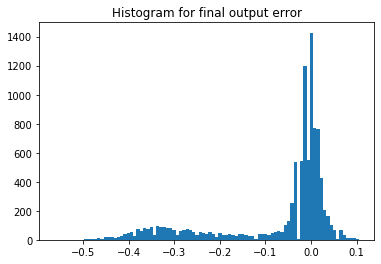

In [13]:
fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for final output error")
plt.show()

In [217]:
# passed test
# 1. unipolar,     scaled,     biased: passed
# 2. unipolar,     scaled, non-biased: passed
# 3. unipolar, non-scaled,     biased: passed
# 4. unipolar, non-scaled, non-biased: passed
# 5.  bipolar,     scaled,     biased: passed
# 6.  bipolar,     scaled, non-biased: passed
# 7.  bipolar, non-scaled,     biased: passed
# 8.  bipolar, non-scaled, non-biased: passed